# PROBLEM 2

## OBJECTIVES

### Calculate the Dropoff Rate:
- Calculate the number of patients who stop taking "Target Drug" each month.
- The dropoff rate is defined as the number of patients who drop off the treatment in a given month.
     
###  Analyze Events Leading to Dropoff:
- Identify the events or factors that lead to patients discontinuing the "Target Drug" treatment.
- Generate insights into why patients are stopping the treatment prematurely.

IMPORTING LIBRARIES

In [133]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
pd.options.mode.chained_assignment = None  # ignore warnings

In [92]:
df_train = pd.read_parquet("train.parquet") # loading parquet file
df_train.head()

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1


# DATA PREPROCESSING

In [93]:
# Converting Date column to datetime
df_train['Date'] = pd.to_datetime(df_train['Date'])

# Sorting df by patient_id and Date
df_train.sort_values(by=['Patient-Uid', 'Date'], inplace=True)

#removing space in the TARGET_DRUG which  create problems in model building
df_train['Incident'] = df_train['Incident'].replace('TARGET DRUG', 'TARGET_DRUG')

# Grouping by patient_id and aggregating Incident column
organised_df = df_train.groupby('Patient-Uid')['Incident'].apply(lambda x: ' '.join(x)).reset_index()

organised_df.head(10)

,Patient-Uid,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,DRUG_TYPE_7 SYMPTOM_TYPE_2 DRUG_TYPE_7 SYMPTOM...
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,DRUG_TYPE_0 DRUG_TYPE_2 DRUG_TYPE_0 PRIMARY_DI...
2,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,DRUG_TYPE_0 PRIMARY_DIAGNOSIS DRUG_TYPE_7 DRUG...
3,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,DRUG_TYPE_0 DRUG_TYPE_7 DRUG_TYPE_2 PRIMARY_DI...
4,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,DRUG_TYPE_1 TEST_TYPE_1 SYMPTOM_TYPE_8 DRUG_TY...
5,a0dc9577-1c7c-11ec-8b4d-16262ee38c7f,DRUG_TYPE_1 DRUG_TYPE_1 DRUG_TYPE_1 DRUG_TYPE_...
6,a0dc95c6-1c7c-11ec-8e77-16262ee38c7f,DRUG_TYPE_2 DRUG_TYPE_0 DRUG_TYPE_6 DRUG_TYPE_...
7,a0dc95f9-1c7c-11ec-b968-16262ee38c7f,DRUG_TYPE_9 DRUG_TYPE_6 DRUG_TYPE_6 DRUG_TYPE_...
8,a0dc962a-1c7c-11ec-8a51-16262ee38c7f,DRUG_TYPE_6 DRUG_TYPE_0 DRUG_TYPE_3 SYMPTOM_TY...
9,a0dc9659-1c7c-11ec-a91e-16262ee38c7f,DRUG_TYPE_0 DRUG_TYPE_1 DRUG_TYPE_11 DRUG_TYPE...


In [94]:
organised_df.shape # shape of organised df

(27033, 2)

## COMPUTING DROP OFF RATES

### POSITIVE DATAFRAME

In [95]:
# rows which includes only the TARGET_DRUG
pos_df = organised_df[organised_df['Incident'].str.contains('TARGET_DRUG')]

pos_df.shape

(9374, 2)

In [96]:
pos_df.head() 

,Patient-Uid,Incident
17659,a0e9c384-1c7c-11ec-81a0-16262ee38c7f,DRUG_TYPE_7 TEST_TYPE_0 DRUG_TYPE_0 DRUG_TYPE_...
17660,a0e9c3b3-1c7c-11ec-ae8e-16262ee38c7f,PRIMARY_DIAGNOSIS DRUG_TYPE_2 DRUG_TYPE_2 PRIM...
17661,a0e9c3e3-1c7c-11ec-a8b9-16262ee38c7f,DRUG_TYPE_5 DRUG_TYPE_5 DRUG_TYPE_7 SYMPTOM_TY...
17662,a0e9c414-1c7c-11ec-889a-16262ee38c7f,DRUG_TYPE_9 DRUG_TYPE_7 DRUG_TYPE_7 SYMPTOM_TY...
17663,a0e9c443-1c7c-11ec-9eb0-16262ee38c7f,DRUG_TYPE_8 DRUG_TYPE_7 SYMPTOM_TYPE_0 DRUG_TY...


In [97]:
# listing all the incident dates for each patient and adding it to the dataset
grouped_dates=[]

for patient_id in tqdm(list(pos_df['Patient-Uid'].values)):
    each_patient_data = df_train[df_train['Patient-Uid']==patient_id]['Date'].values
    grouped_dates.append(each_patient_data)

print(len(grouped_dates))

  0%|          | 0/9374 [00:00<?, ?it/s]

100%|██████████| 9374/9374 [20:49<00:00,  7.50it/s]

9374


In [98]:
# creating new column with grouped dates
pos_df['Date_sequence']=grouped_dates
pos_df.head()

,Patient-Uid,Incident,Date_sequence
17659,a0e9c384-1c7c-11ec-81a0-16262ee38c7f,DRUG_TYPE_7 TEST_TYPE_0 DRUG_TYPE_0 DRUG_TYPE_...,"[2015-04-14T00:00:00.000000, 2015-09-07T00:00:..."
17660,a0e9c3b3-1c7c-11ec-ae8e-16262ee38c7f,PRIMARY_DIAGNOSIS DRUG_TYPE_2 DRUG_TYPE_2 PRIM...,"[2015-04-16T00:00:00.000000, 2015-04-23T00:00:..."
17661,a0e9c3e3-1c7c-11ec-a8b9-16262ee38c7f,DRUG_TYPE_5 DRUG_TYPE_5 DRUG_TYPE_7 SYMPTOM_TY...,"[2015-09-16T00:00:00.000000, 2015-11-13T00:00:..."
17662,a0e9c414-1c7c-11ec-889a-16262ee38c7f,DRUG_TYPE_9 DRUG_TYPE_7 DRUG_TYPE_7 SYMPTOM_TY...,"[2015-05-01T00:00:00.000000, 2015-05-01T00:00:..."
17663,a0e9c443-1c7c-11ec-9eb0-16262ee38c7f,DRUG_TYPE_8 DRUG_TYPE_7 SYMPTOM_TYPE_0 DRUG_TY...,"[2015-04-16T00:00:00.000000, 2015-09-11T00:00:..."


In [99]:
# list of those dates in which the target_drug is taken by the patient and adding it to the dataset
date_of_tar_drug=[]
for j in tqdm(range(pos_df.shape[0])):
    pat_wise_tar_grug=[]
    for i, incident in enumerate(pos_df.iloc[j]['Incident'].split()):
        if incident=="TARGET_DRUG":
            pat_wise_tar_grug.append(pos_df.iloc[j]['Date_sequence'][i])
    
    date_of_tar_drug.append(pat_wise_tar_grug)
        

100%|██████████| 9374/9374 [00:02<00:00, 4417.03it/s]


In [100]:
# creating new column of date target_drug is taken by the patient
pos_df['date_of_tar_drug']=date_of_tar_drug
pos_df.head()

,Patient-Uid,Incident,Date_sequence,date_of_tar_drug
17659,a0e9c384-1c7c-11ec-81a0-16262ee38c7f,DRUG_TYPE_7 TEST_TYPE_0 DRUG_TYPE_0 DRUG_TYPE_...,"[2015-04-14T00:00:00.000000, 2015-09-07T00:00:...","[2020-07-08T00:00:00.000000, 2020-08-05T00:00:..."
17660,a0e9c3b3-1c7c-11ec-ae8e-16262ee38c7f,PRIMARY_DIAGNOSIS DRUG_TYPE_2 DRUG_TYPE_2 PRIM...,"[2015-04-16T00:00:00.000000, 2015-04-23T00:00:...","[2018-04-24T00:00:00.000000, 2018-05-17T00:00:..."
17661,a0e9c3e3-1c7c-11ec-a8b9-16262ee38c7f,DRUG_TYPE_5 DRUG_TYPE_5 DRUG_TYPE_7 SYMPTOM_TY...,"[2015-09-16T00:00:00.000000, 2015-11-13T00:00:...","[2019-10-31T00:00:00.000000, 2019-12-12T00:00:..."
17662,a0e9c414-1c7c-11ec-889a-16262ee38c7f,DRUG_TYPE_9 DRUG_TYPE_7 DRUG_TYPE_7 SYMPTOM_TY...,"[2015-05-01T00:00:00.000000, 2015-05-01T00:00:...","[2018-04-05T00:00:00.000000, 2018-06-24T00:00:..."
17663,a0e9c443-1c7c-11ec-9eb0-16262ee38c7f,DRUG_TYPE_8 DRUG_TYPE_7 SYMPTOM_TYPE_0 DRUG_TY...,"[2015-04-16T00:00:00.000000, 2015-09-11T00:00:...","[2019-09-10T00:00:00.000000, 2019-10-10T00:00:..."


In [101]:
#storing the number of patients dropping of each month 
counts_per_month={}

#collecting the list of patients who stopped using target_drug 
list_of_dropoff_patients=[]

#Looping through the target_drug usage dates of each patient
for i,L in enumerate(tqdm(date_of_tar_drug)):

    #checking the difference in dates of first usage and last usage if it is < 365, then it is the case of droppoff
    if int((L[-1]-L[0])/ np.timedelta64(1, 'D')) < 365:
        list_of_dropoff_patients.append(i)
        if np.datetime_as_string(L[0], unit='M') not in counts_per_month:
            counts_per_month[np.datetime_as_string(L[0], unit='M')]=1
        else:
            counts_per_month[np.datetime_as_string(L[0], unit='M')]+=1

counts_per_month


100%|██████████| 9374/9374 [00:00<00:00, 102467.26it/s]


{'2020-07': 269,
 '2019-10': 325,
 '2019-09': 230,
 '2020-02': 225,
 '2020-06': 258,
 '2018-12': 133,
 '2019-03': 110,
 '2018-08': 167,
 '2019-01': 141,
 '2018-05': 185,
 '2020-04': 293,
 '2019-05': 190,
 '2018-06': 187,
 '2019-02': 107,
 '2018-11': 128,
 '2019-11': 252,
 '2018-10': 142,
 '2018-03': 183,
 '2019-07': 167,
 '2019-12': 279,
 '2019-04': 148,
 '2019-06': 163,
 '2020-01': 254,
 '2020-03': 233,
 '2020-05': 256,
 '2018-09': 131,
 '2017-12': 4,
 '2018-07': 155,
 '2018-04': 215,
 '2017-10': 4,
 '2019-08': 239,
 '2018-01': 5,
 '2018-02': 6,
 '2017-11': 1,
 '2017-08': 2}

## PLOTTING DROP OF RATES

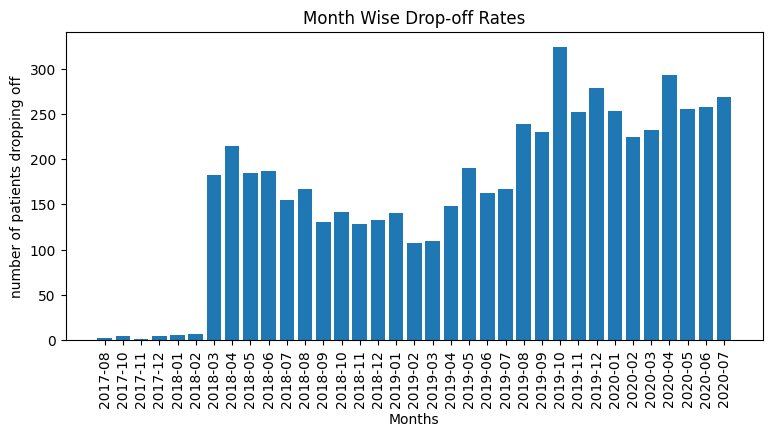

In [102]:
#Sorting  the keys in order, to have the x-axis as the timeline
keys_list = sorted(list(counts_per_month.keys()))
#getting the coreesponding values
values_list= [counts_per_month[key] for key in keys_list]

#Ploting in the format of a bar graph - Month Wise Drop-off Rates
plt.figure(figsize=(9,4))
plt.bar(keys_list,values_list)
plt.title("Month Wise Drop-off Rates")
plt.xlabel('Months')
plt.ylabel('number of patients dropping off')
plt.xticks(rotation=90)
plt.show()

## COMPUTING EVENTS LEADS TO DROP OFF

In [148]:
df_2 = pd.read_parquet("train.parquet")

In [149]:
df_2.head()

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1


In [150]:
# df contains target drug taken patients only
pos_df = df_2[df_2['Incident'] == 'TARGET DRUG']


In [151]:
# Calculating the dropoff rate by month
pos_df['Date'] = pd.to_datetime(pos_df['Date'])
pos_df['Month'] = pos_df['Date'].dt.month
dropoff_rates = pos_df.groupby('Month')['Patient-Uid'].nunique().diff().fillna(0)

In [152]:

# analyzing events driving dropp-off
do_resn = df_2[df_2['Patient-Uid'].isin(pos_df['Patient-Uid'])]
do_resn = do_resn[do_resn['Date'] < do_resn.groupby('Patient-Uid')['Date'].transform('max')]
do_resn = do_resn[do_resn['Incident'] != 'TARGET DRUG']

In [153]:
# calculating the frequency of each event leading to drop-off
freq_of_incidents = do_resn['Incident'].value_counts()


## PLOTTING EVENTS LEADS TO DROP OFF

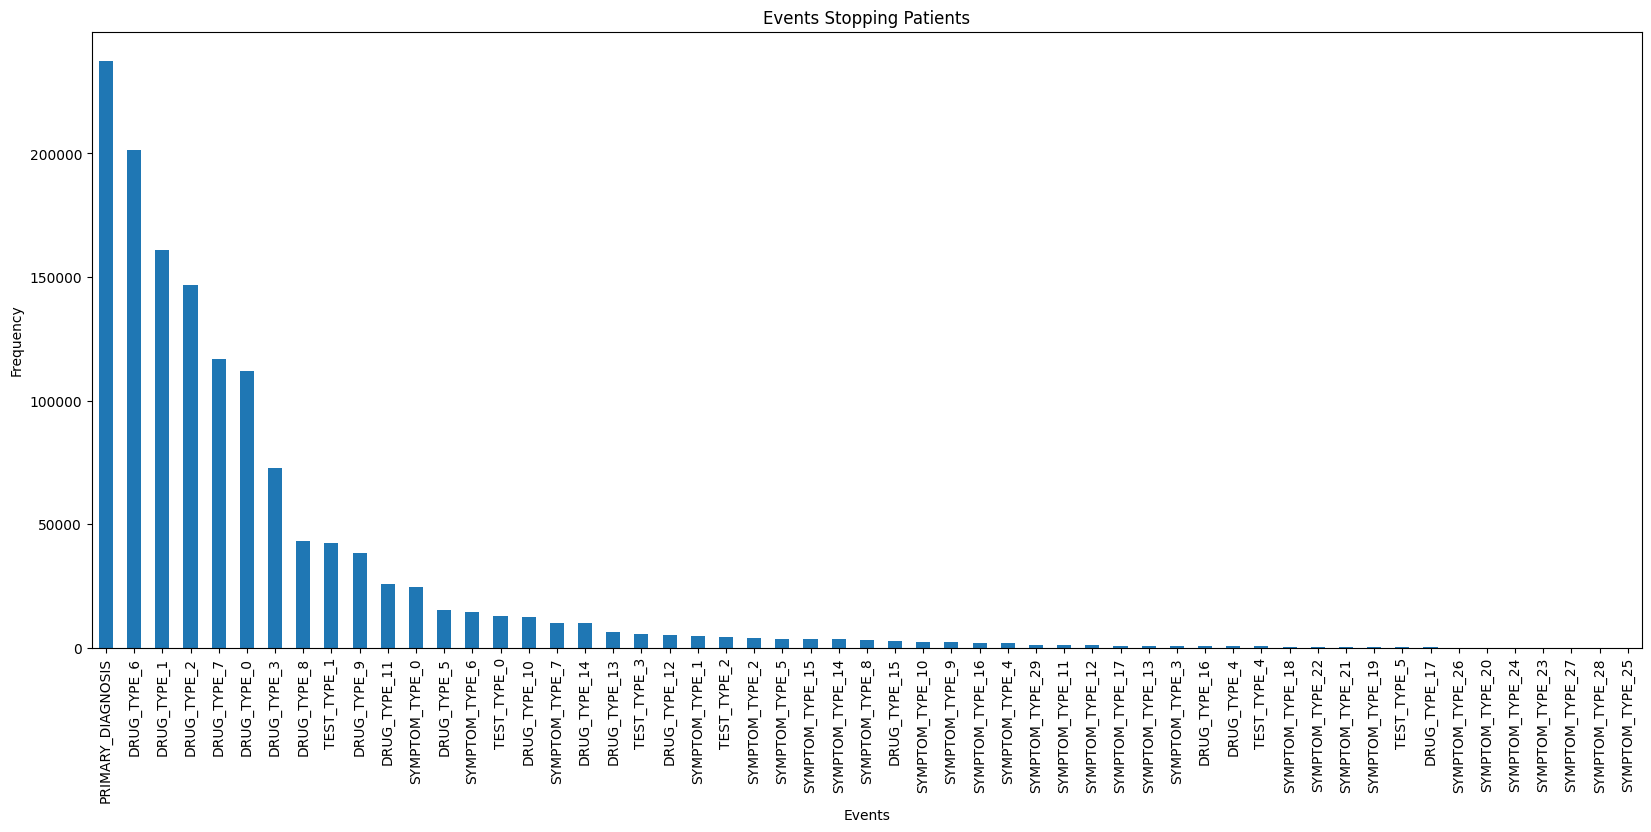

In [154]:
# Plot the events leading to drop-off
plt.figure(figsize=(20, 8))
freq_of_incidents.plot(kind='bar')
plt.xlabel('Events')
plt.ylabel('Frequency')
plt.title('Events Stopping Patients')
plt.show()  